<a href="https://colab.research.google.com/github/Ssavan99/Formula1RacePredictor/blob/main/f1DataVisualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade geopandas

In [ ]:
pip install squarify

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium
import plotly.express as px
import seaborn as sns
import squarify


%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_path = '/content/drive/MyDrive/f1DataAnalysis/'
Const_sta = pd.read_csv(os.path.join(drive_path, 'ConstructorStandings.csv'))
Dri_sta = pd.read_csv(os.path.join(drive_path, 'DriverStandings.csv'))
races = pd.read_csv(os.path.join(drive_path, 'Races.csv'))
results = pd.read_csv(os.path.join(drive_path, 'Results.csv'))
Wea_info = pd.read_csv(os.path.join(drive_path, 'WeatherInfo.csv'))
Qua_results = pd.read_csv(os.path.join(drive_path, 'QualifyingResults.csv'))

Task 1: frequency of race in a circuit by year(1950-2019)

In [ ]:
races.drop(columns=['Unnamed: 0'],inplace=True)

In [ ]:
races.head()

,season,round,circuit_id,lat,long,country,date,url
0,1950,1,silverstone,52.0786,-1.01694,UK,1950-05-13,http://en.wikipedia.org/wiki/1950_British_Gran...
1,1950,2,monaco,43.7347,7.42056,Monaco,1950-05-21,http://en.wikipedia.org/wiki/1950_Monaco_Grand...
2,1950,3,indianapolis,39.7950,-86.23470,USA,1950-05-30,http://en.wikipedia.org/wiki/1950_Indianapolis...
3,1950,4,bremgarten,46.9589,7.40194,Switzerland,1950-06-04,http://en.wikipedia.org/wiki/1950_Swiss_Grand_...
4,1950,5,spa,50.4372,5.97139,Belgium,1950-06-18,http://en.wikipedia.org/wiki/1950_Belgian_Gran...


In [ ]:
race_by_year = races.groupby('season')['circuit_id'].value_counts()

In [ ]:
year_l = []
circuit_l = []
count_l = []

for year,circuit in race_by_year.index:
  year_l.append(year)
  circuit_l.append(circuit)
  count_l.append(race_by_year.loc[(year,circuit)])

In [ ]:
race_tot = races.groupby('circuit_id')['circuit_id'].count()

In [ ]:
race_tot

circuit_id
BAK             4
adelaide       11
ain-diab        1
aintree         5
albert_park    24
               ..
yas_marina     11
yeongam         4
zandvoort      30
zeltweg         1
zolder         10
Name: circuit_id, Length: 72, dtype: int64

In [ ]:
circuits_uni = [circuit for circuit in race_tot.index]

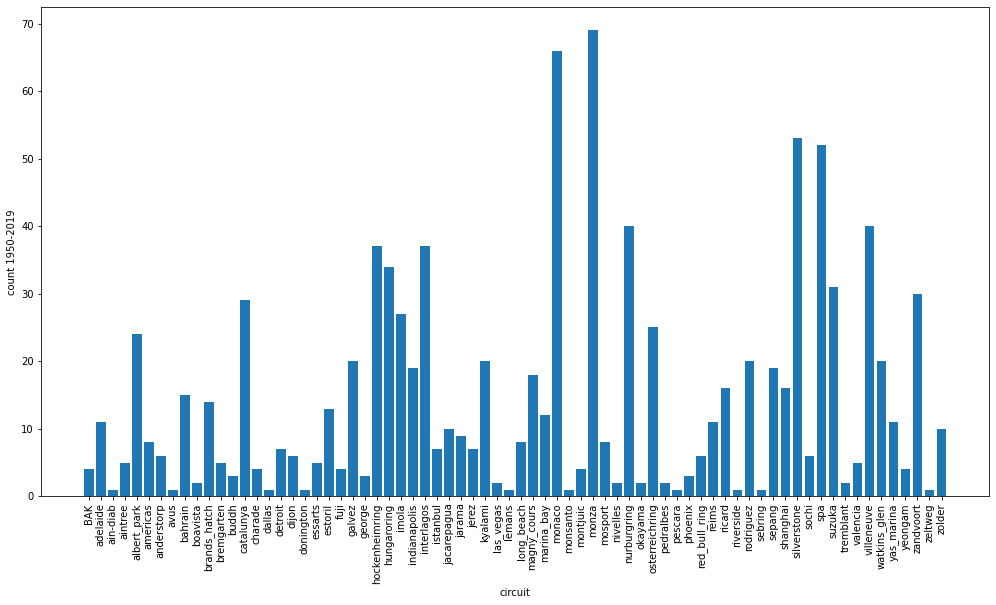

In [ ]:
plt.subplots(figsize=(17,9))
plt.bar(circuits_uni,race_tot,width=0.8)
plt.xticks(circuits_uni,rotation='vertical',size=10)
plt.xlabel('circuit')
plt.ylabel('count 1950-2019')
plt.show()

In [ ]:
circuit_num = {}
a = races['circuit_id'].unique()
for i in range(len(a)):
  circuit_num[a[i]] = i

In [ ]:
circuit_id_l = [circuit_num[i] for i in circuit_l]

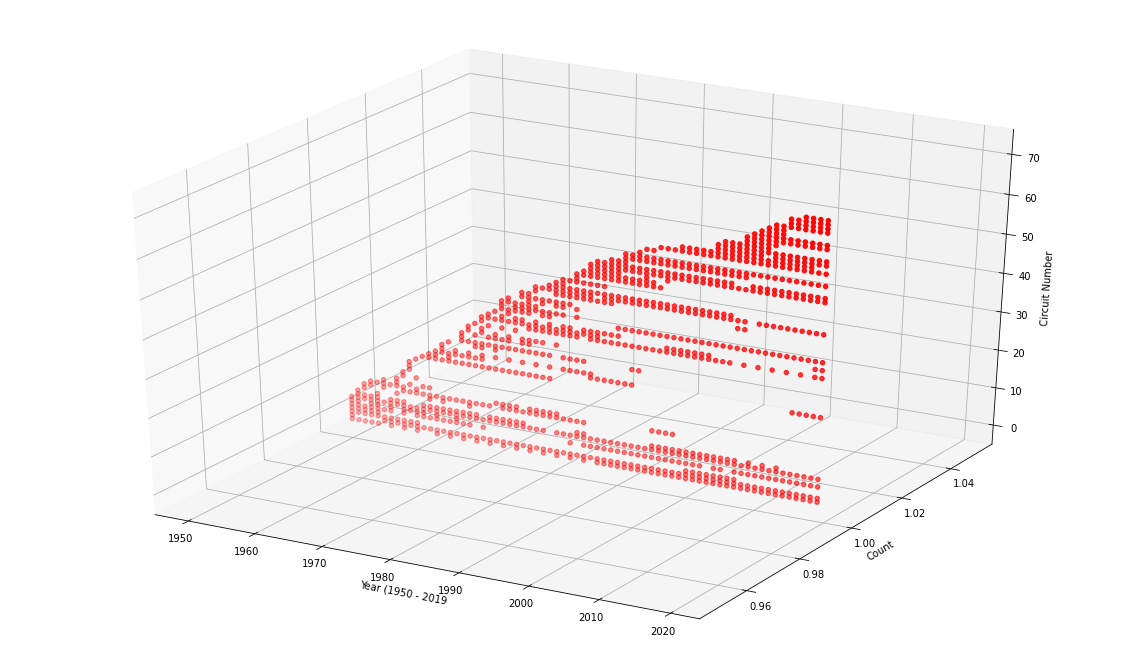

In [ ]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111,projection='3d')
frequency_graph = ax.scatter(year_l,count_l,circuit_id_l,c='r',marker='o')
#frequency_graph.set_label(circuit_num)
ax.set_xlabel("Year (1950 - 2019")
ax.set_ylabel("Count")
ax.set_zlabel("Circuit Number")
#ax.legend()
plt.show()

In [ ]:
geometry = gpd.points_from_xy(races.long, races.lat)
geo_races = gpd.GeoDataFrame(races[['season','round','circuit_id', 'lat', 'long', 'country', 'date', 'url']], geometry=geometry)

Text(0.5, 1.0, 'Circuit locations')

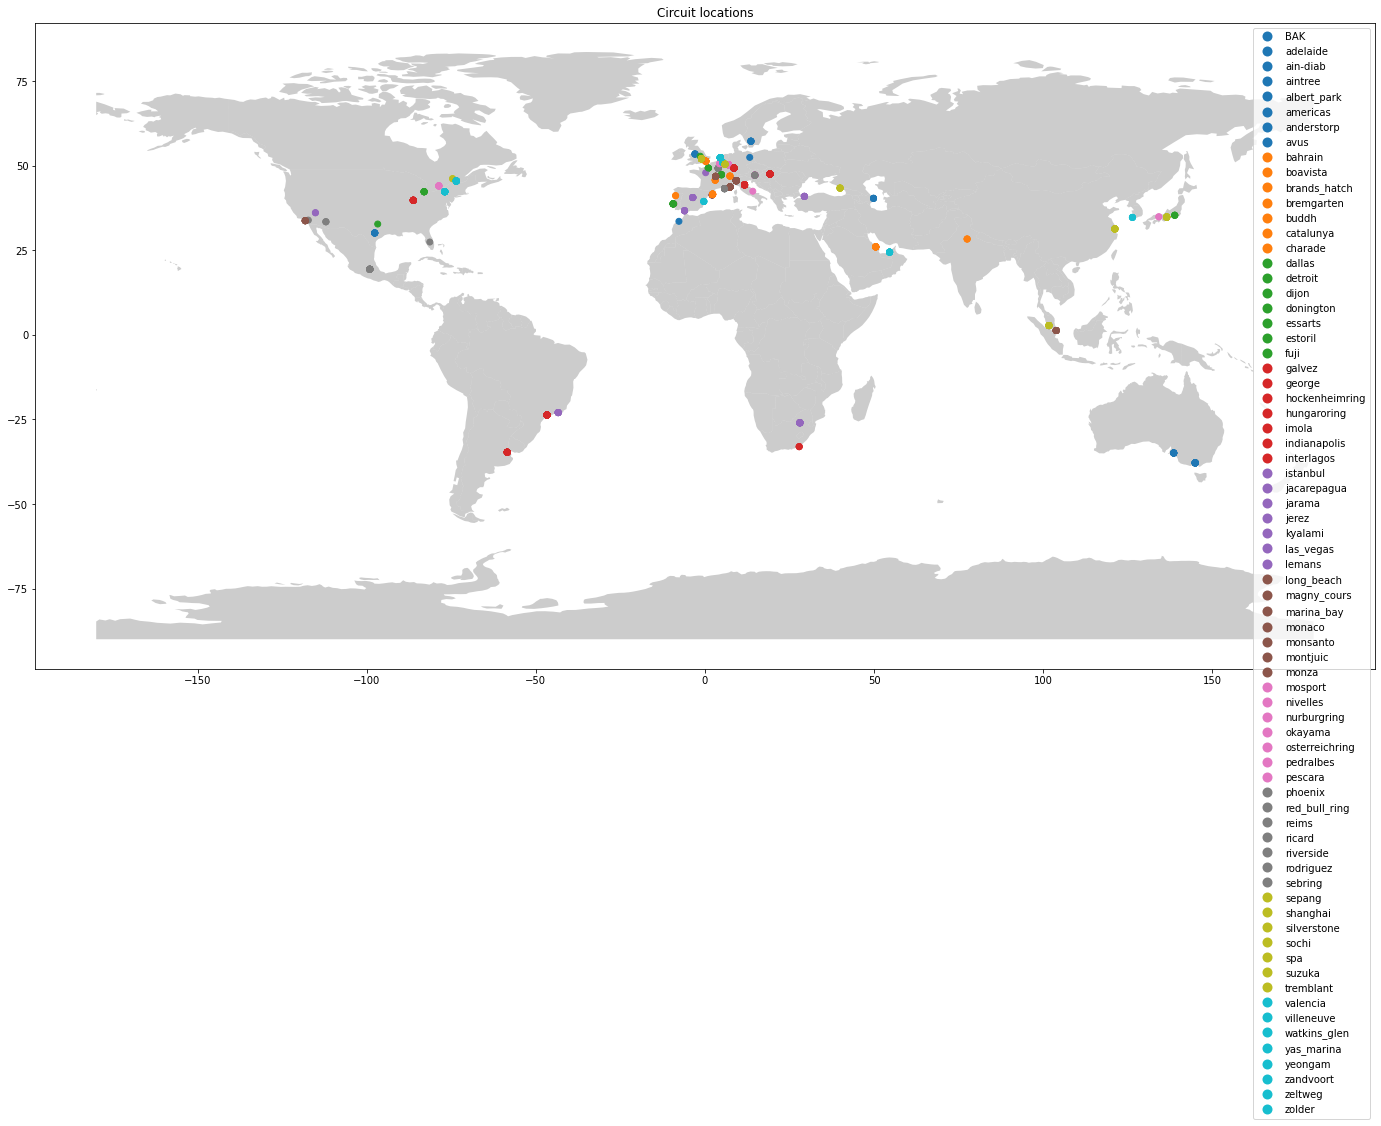

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(24,18))
world.plot(ax=ax, alpha=0.4, color='grey')
geo_races.plot(column='circuit_id', ax=ax, legend=True)
plt.title('Circuit locations')

In [ ]:
map = folium.Map(location = [4,10], tiles = "Stamen Terrain", zoom_start = 3)
geo_races_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_races.geometry ]
i = 0
for coordinates in geo_races_list:
  map.add_child(folium.Marker(location = coordinates, popup = "Circuit: " + str(geo_races.circuit_id[i]) + '<br>', icon = folium.Icon(color = "%s")))
  i=i+1

map

Task 2:coorelation between grid and podium

In [ ]:
results.drop(columns=['Unnamed: 0'],inplace=True)

In [ ]:
dri_results = results[['circuit_id','driver','grid','podium']]

In [ ]:
dri_results.head()

,circuit_id,driver,grid,podium
0,silverstone,farina,1,1
1,silverstone,fagioli,2,2
2,silverstone,reg_parnell,4,3
3,silverstone,cabantous,6,4
4,silverstone,rosier,9,5


In [ ]:
b = dri_results.groupby('circuit_id')[['grid','podium']].corr()['podium']
filt = (b != 1)
b = b.loc[filt]

In [ ]:
circuit_t2 = []
corr_values = []
for circuit,grid in b.index:
  circuit_t2.append(circuit)
  corr_values.append(b.loc[circuit,grid])

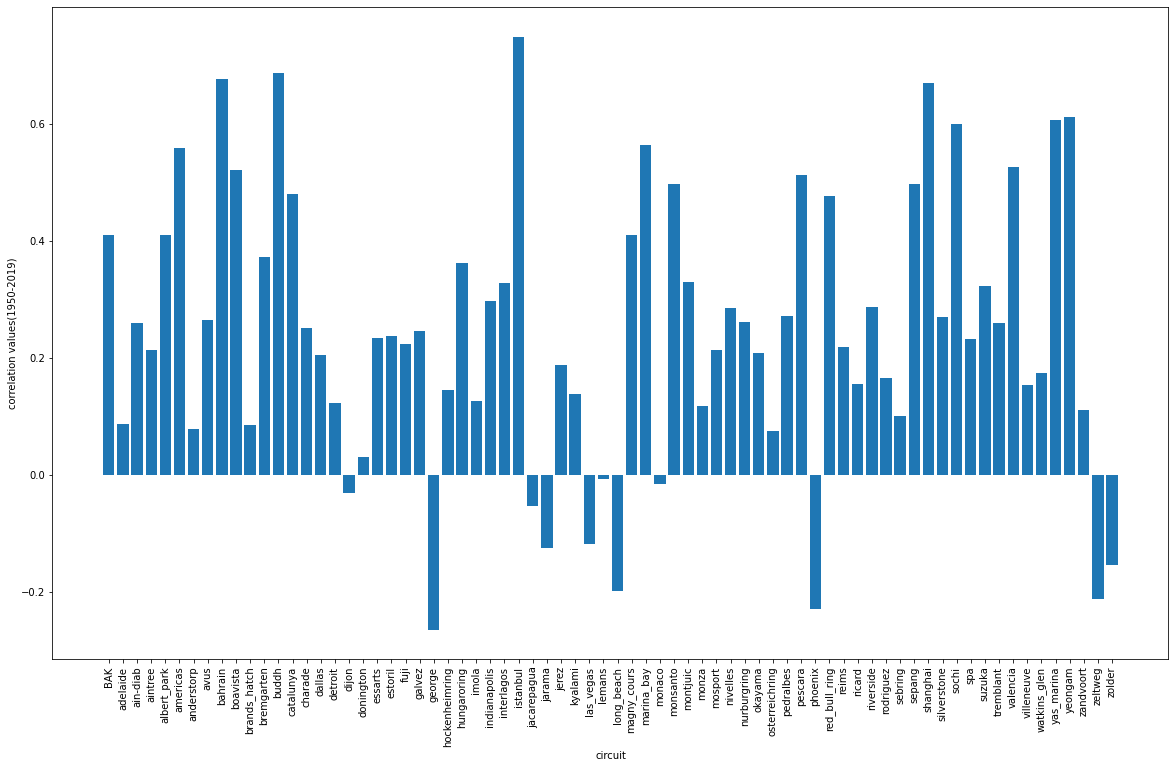

In [ ]:
plt.subplots(figsize=(20,12))
plt.bar(circuit_t2,corr_values,width=0.8)
plt.xticks(circuit_t2,rotation='vertical',size=10)
plt.xlabel('circuit')
plt.ylabel('correlation values(1950-2019)')
plt.show()

Task 3: car failures

In [ ]:
results.head()
filt = results['season'] > 1990 #getting data after year
result_fil = results.loc[filt] 

In [ ]:
car_failures = ['Engine','Brake','Transmission','Suspension'] # defining basis of car failure 
races_per_constructor = result_fil.groupby('constructor')['status'].count() #grouping on the basis of constructor and counting number of races per constructor

In [ ]:
failure_filt = result_fil['status'].isin(car_failures) #defining a filter for filtering our data frame to df having only failures
failure_filtered = result_fil.loc[failure_filt] #executing the filter and storing df in a variable
failures_per_contructor = failure_filtered.groupby('constructor')['status'].count() #grouping on the basis of constructor and counting number of failures per constructor 
uncommon_constructors = [] #defining a list to drop the uncommon constructors, because those companies never made a mistake
for i in races_per_constructor.index: #loop to find uncommon constructors
  if i not in failures_per_contructor.index:
    uncommon_constructors.append(i)

In [ ]:
zeros = [0 for i in uncommon_constructors]
no_fail = pd.Series(zeros,index=uncommon_constructors)
failures_per_contructor = failures_per_contructor.append(no_fail)
failures_per_contructor.sort_index(inplace=True)
races_per_constructor.sort_index(inplace=True)

In [ ]:
df = pd.DataFrame({'unsuccessful': failures_per_contructor,'total races':races_per_constructor}) #combining a and c into a df
df['percentage failure'] = (df['unsuccessful'] / df['total races'])*100  #defining a new column for percentage

In [ ]:
df.head()

,unsuccessful,total races,percentage failure
constructor,,,
ags,1,18,5.555556
alfa,0,42,0.000000
arrows,36,190,18.947368
bar,28,236,11.864407
benetton,34,360,9.444444


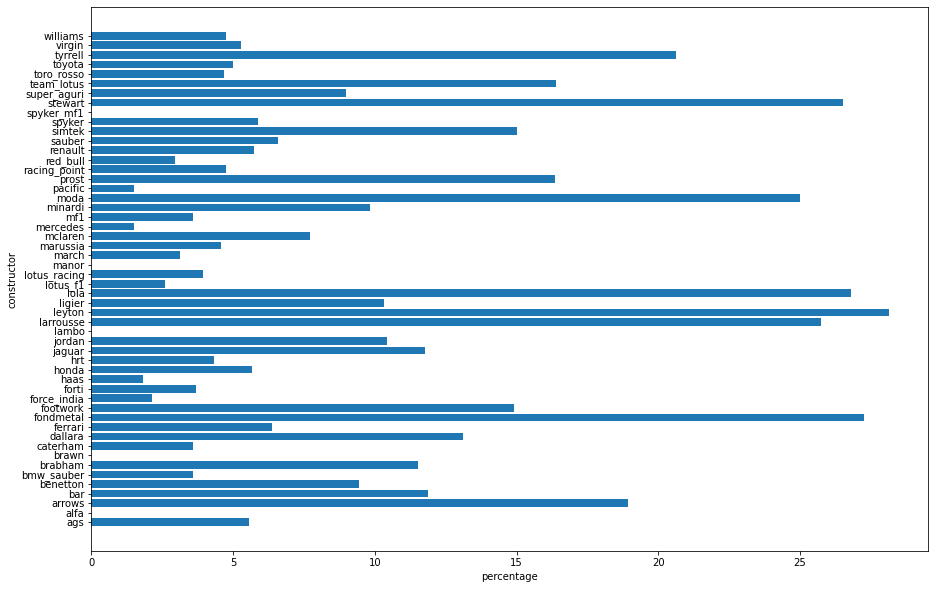

In [ ]:
plt.subplots(figsize=(15,10))
plt.barh(df.index,df['percentage failure'])
plt.yticks(df.index,size=10)
plt.xlabel('percentage')
plt.ylabel('constructor')
plt.show()

In [ ]:
circuit_incidents = ['Accident','Collision','Collision damage','Damage']
incidents_filt = result_fil['status'].isin(circuit_incidents)
incidents_filtered = result_fil.loc[incidents_filt]
incidents_per_contructor = incidents_filtered.groupby('circuit_id')['status'].count()
incidents_circuits = [i for i in incidents_per_contructor.index]
incidents_per_contructor.to_csv()
print(incidents_per_contructor)
#result_fil.groupby('circuit_id')['status'].unique()
#result_fil['status'].unique()

circuit_id
BAK                9
adelaide          15
albert_park       62
americas          10
bahrain            9
buddh              5
catalunya         46
donington          3
estoril           11
fuji               6
galvez            15
hockenheimring    43
hungaroring       32
imola             12
indianapolis      22
interlagos        62
istanbul           5
jerez              1
kyalami            5
magny_cours       18
marina_bay        29
monaco            79
monza             44
nurburgring       26
okayama            5
osterreichring    15
phoenix            1
red_bull_ring      5
ricard             2
rodriguez          5
sepang            15
shanghai          17
silverstone       35
sochi             11
spa               57
suzuka            38
valencia           7
villeneuve        57
yas_marina        11
yeongam           14
Name: status, dtype: int64


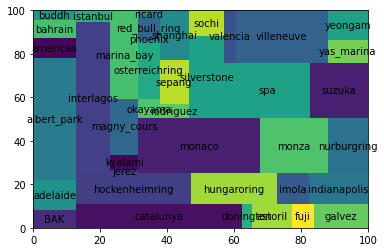

In [ ]:
squarify.plot(sizes=incidents_per_contructor,label= incidents_circuits, alpha=1)

In [ ]:
fig = px.treemap(result_fil,
                 path=['circuit_id'],
                 values=incidents_per_contructor)

fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

TypeError: ignored